In [240]:
import pandas as pd

df = pd.read_csv("split_data.csv")
df = df[df["split"] == "training"]
df

,Unnamed: 0,study_id,series_id,image_id,laterality,view_position,height,width,breast_birads,breast_density,split
0,0,b8d273e8601f348d3664778dae0e7e0b,b36517b9cbbcfd286a7ae04f643af97a,d8125545210c08e1b1793a5af6458ee2,L,CC,3518,2800,BI-RADS 2,DENSITY C,training
1,1,b8d273e8601f348d3664778dae0e7e0b,b36517b9cbbcfd286a7ae04f643af97a,290c658f4e75a3f83ec78a847414297c,L,MLO,3518,2800,BI-RADS 2,DENSITY C,training
4,4,8269f5971eaca3e5d3772d1796e6bd7a,d931832a0815df082c085b6e09d20aac,dd9ce3288c0773e006a294188aadba8e,L,CC,3518,2800,BI-RADS 1,DENSITY C,training
5,5,8269f5971eaca3e5d3772d1796e6bd7a,d931832a0815df082c085b6e09d20aac,57fbdd278af5c8789a02b355c11620d4,L,MLO,3518,2800,BI-RADS 1,DENSITY C,training
7,7,8269f5971eaca3e5d3772d1796e6bd7a,d931832a0815df082c085b6e09d20aac,acccc1727b61b261844d86aa9de53536,R,MLO,3518,2800,BI-RADS 1,DENSITY C,training
...,...,...,...,...,...,...,...,...,...,...,...
15995,15995,f2093a752e6b44df5990f5fd38c99dd2,2b1b2b8f48abab9819c0b3d091e152ee,ea732154d149f619b20070b78060ae65,R,CC,2812,2012,BI-RADS 2,DENSITY C,training
15996,15996,b3c8969cd2accfa4dbb2aece1f7158ab,69d7f07ea04572dad5e5aa62fbcfc4b7,4689616c3d0b46fcba7a771107730791,R,CC,3580,2702,BI-RADS 2,DENSITY C,training
15997,15997,b3c8969cd2accfa4dbb2aece1f7158ab,69d7f07ea04572dad5e5aa62fbcfc4b7,3c22491bcf1d0b004715c28d80981cdd,L,CC,3580,2702,BI-RADS 2,DENSITY C,training
15998,15998,b3c8969cd2accfa4dbb2aece1f7158ab,69d7f07ea04572dad5e5aa62fbcfc4b7,d443b9725e331b8b27589aa725597801,R,MLO,3580,2686,BI-RADS 2,DENSITY C,training


In [241]:
sampled_df = df.groupby('breast_birads', group_keys=False).apply(lambda x: x.sample(min(len(x), 100))).reset_index(drop=True)
print(sampled_df["breast_birads"].value_counts())

breast_birads
BI-RADS 1    100
BI-RADS 2    100
BI-RADS 3    100
BI-RADS 4    100
BI-RADS 5    100
Name: count, dtype: int64


In [242]:
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms
import os

class Mydataset(Dataset):
    def __init__(self, df, root):
        super(Mydataset, self).__init__()
        self.root = root
        image_paths_df = df["study_id"] + "/" + df["image_id"] +".png"
        self.image_paths = image_paths_df.tolist()
        label_df = df["breast_birads"]
        self.labels = label_df.tolist()
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root, self.image_paths[idx])
        img = self._read_image(img_path, (224,224))
        label = int(self.labels[idx][-1])
        return img, torch.tensor(label).to(torch.long)
    
    def _read_image(self, filepath, new_size):
        image_pil = Image.open(filepath)
        
        # Kiểm tra chế độ của ảnh
        if image_pil.mode != 'L':
            image_pil = image_pil.convert('L')  # Chuyển đổi sang chế độ 'L' (grayscale) nếu cần thiết
        
        # Tạo ảnh RGB từ ảnh đơn kênh bằng cách sao chép giá trị của kênh đó vào cả ba kênh
        image_pil = Image.merge('RGB', (image_pil, image_pil, image_pil))
        
        # Resize ảnh
        transform = transforms.Compose([
            transforms.Resize(new_size),
            transforms.ToTensor()
        ])
        resized_image = transform(image_pil)
        resized_image = resized_image.to(torch.float)
        
        return resized_image
        

In [243]:
from torch import nn
import torch
import torchvision.models as models
import timm

class FeatureExtractModel(nn.Module):
    def __init__(self, model_name: str, embed_dim: int):
        """
        A custom model for Setting 3, which uses different pre-trained models
        based on the specified `model_name`.

        Args:
        - model_name: Name of the pre-trained model to be used
        - embed_dim: Dimension of the output embeddings
        """
        super(FeatureExtractModel, self).__init__()

        # Load the specified pre-trained model
        if model_name.startswith('resnet'):
            if model_name == 'resnet50':
                self.model = models.resnet50(pretrained=True)
            elif model_name == 'resnet101':
                self.model = models.resnet101(pretrained=True)
            elif model_name == 'resnet152':
                self.model = models.resnet152(pretrained=True)
            else:
                raise ValueError(f"Unsupported ResNet model: {model_name}")
                
            num_features = self.model.fc.in_features
            self.model.fc = nn.Linear(num_features, embed_dim)
        
        elif model_name.startswith('densenet'):
            if model_name == 'densenet121':
                self.model = models.densenet121(pretrained=True)
            else:
                raise ValueError(f"Unsupported DenseNet model: {model_name}")
                
            num_features = self.model.classifier.in_features
            self.model.classifier = nn.Linear(num_features, embed_dim)
        
        elif model_name.startswith('vit'):
            self.model = timm.create_model(model_name, pretrained=True)

            num_features = self.model.head.in_features
            self.model.head = nn.Linear(num_features, embed_dim)
        
        else:
            raise ValueError(f"Unsupported model: {model_name}")
    
    def forward(self, image):
        return self.model(image)

In [244]:
from torch.utils.data import DataLoader
import os

dataset = Mydataset(sampled_df, "/media/jackson/Data/archive/Processed_Images")
dataloader = DataLoader(dataset, batch_size=16, shuffle=False, num_workers=os.cpu_count())

model = FeatureExtractModel("vit_base_patch16_224", 512)
check_point = torch.load("version 2/weights_setting3/vit_base_patch16_224BasedModel/best.pt", map_location = torch.device("cpu"))
model.load_state_dict(check_point["model_state_dict"])

<All keys matched successfully>

In [245]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm
# Lấy embeddings từ mô hình
embeddings = []
labels = []
device = torch.device( "cpu")
model.eval()
model = model.to(device)
with torch.no_grad():
    for data in tqdm(dataloader):
        inputs, target_labels = data
        inputs = inputs.to(device)
        output_embeddings = model(inputs)
        embeddings.append(output_embeddings)
        labels.append(target_labels)

# Chuyển đổi danh sách thành tensor
embeddings = torch.cat(embeddings).cpu().numpy()
labels = torch.cat(labels).cpu().numpy()


100%|██████████| 32/32 [04:09<00:00,  7.79s/it]


In [246]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(embeddings)

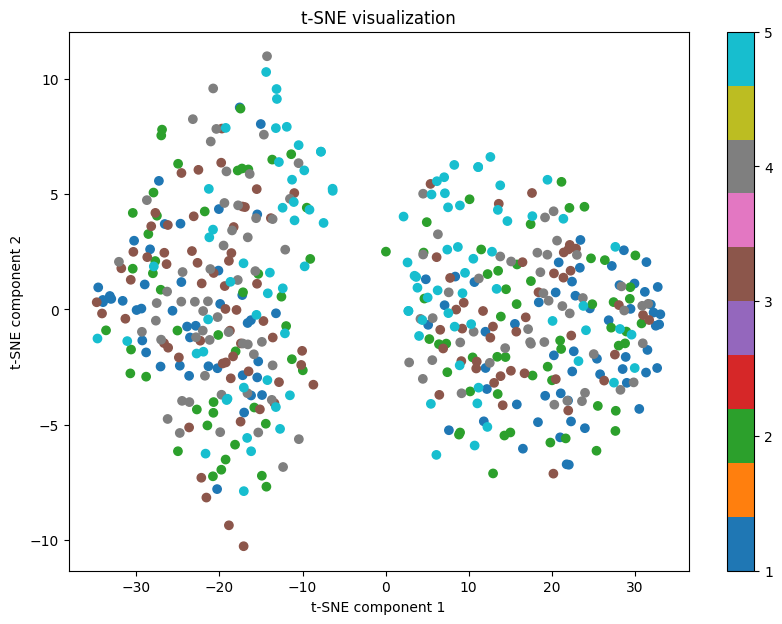

In [247]:
plt.figure(figsize=(10, 7))
scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels, cmap='tab10')
plt.colorbar(scatter, ticks=range(10))
plt.title('t-SNE visualization')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.show()